In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
import requests
import os
from flatten_json import flatten

API_BASE_URL = os.getenv("API_BASE_URL", "http://localhost:8000")  # Utiliser l'IP externe si configuré
endpoint = '/flights-all-past'

try:
    response = requests.get(f"{API_BASE_URL}{endpoint}", timeout=10)
    if response.status_code == 200:
        dict_flattened = (flatten(record, '_') for record in response.json())
        df = pd.DataFrame(dict_flattened)
        df_minimized = df.drop(['MarketingCarrierList_MarketingCarrier_AirlineID',
               'MarketingCarrierList_MarketingCarrier_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_0_AirlineID',
               'MarketingCarrierList_MarketingCarrier_0_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_1_AirlineID',
               'MarketingCarrierList_MarketingCarrier_1_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_2_AirlineID',
               'MarketingCarrierList_MarketingCarrier_2_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_3_AirlineID',
               'MarketingCarrierList_MarketingCarrier_3_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_4_AirlineID',
               'MarketingCarrierList_MarketingCarrier_4_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_5_AirlineID',
               'MarketingCarrierList_MarketingCarrier_5_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_6_AirlineID',
               'MarketingCarrierList_MarketingCarrier_6_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_7_AirlineID',
               'MarketingCarrierList_MarketingCarrier_7_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_8_AirlineID',
               'MarketingCarrierList_MarketingCarrier_8_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_9_AirlineID',
               'MarketingCarrierList_MarketingCarrier_9_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_10_AirlineID',
               'MarketingCarrierList_MarketingCarrier_10_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_11_AirlineID',
               'MarketingCarrierList_MarketingCarrier_11_FlightNumber', 'Departure_Terminal_Gate',
                               'Arrival_Terminal_Name', 'Arrival_Terminal_Gate',
                               'Departure_Terminal_Name',
                               'Status_Description', 'Departure_Status_Description', 'Arrival_Status_Description'], axis=1)
        print(df_minimized.columns)
except Exception as e:
    logger.error(f"Erreur API {endpoint} : {e}")

df_minimized['Departure_Actual_Datetime'] = pd.to_datetime(df['Departure_Actual_Date'] + ' ' + df['Departure_Actual_Time'])
df_minimized['Arrival_Actual_Datetime'] = pd.to_datetime(df['Arrival_Actual_Date'] + ' ' + df['Arrival_Actual_Time'])
df_minimized['Departure_Scheduled_Datetime'] = pd.to_datetime(df['Departure_Scheduled_Date'] + ' ' + df['Departure_Scheduled_Time'])
df_minimized['Arrival_Scheduled_Datetime'] = pd.to_datetime(df['Arrival_Scheduled_Date'] + ' ' + df['Arrival_Scheduled_Time'])
#print(df_minimized.head())

df_w_datetime = df_minimized.drop(['Departure_Actual_Date', 'Departure_Actual_Time', 'Arrival_Actual_Date', 'Arrival_Actual_Time', 'Departure_Scheduled_Date', 'Departure_Scheduled_Time', 'Arrival_Scheduled_Date', 'Arrival_Scheduled_Time'], axis=1)


#df_w_datetime['ts_Departure_Actual_Datetime'] = pd.to_numeric(df_w_datetime['Departure_Actual_Datetime'].values)
#df_w_datetime['ts_Arrival_Actual_Datetime'] = pd.to_numeric(df_w_datetime['Arrival_Actual_Datetime'].values)
#df_w_datetime['ts_Departure_Scheduled_Datetime'] = pd.to_numeric(df_w_datetime['Departure_Scheduled_Datetime'].values)
#df_w_datetime['ts_Arrival_Scheduled_Datetime'] = pd.to_numeric(df_w_datetime['Arrival_Scheduled_Datetime'].values)
print(df_w_datetime.head())
print(df_w_datetime.columns)

Index(['_id', 'Departure_AirportCode', 'Departure_Scheduled_Date',
       'Departure_Scheduled_Time', 'Departure_Actual_Date',
       'Departure_Actual_Time', 'Departure_Status_Code',
       'Departure_weather_time', 'Departure_weather_rain',
       'Departure_weather_snowfall', 'Departure_weather_temperature_2m',
       'Departure_weather_relative_humidity_2m',
       'Departure_weather_wind_speed_100m', 'Departure_weather_cloud_cover',
       'Arrival_AirportCode', 'Arrival_Scheduled_Date',
       'Arrival_Scheduled_Time', 'Arrival_Actual_Date', 'Arrival_Actual_Time',
       'Arrival_Status_Code', 'Arrival_weather_time', 'Arrival_weather_rain',
       'Arrival_weather_snowfall', 'Arrival_weather_temperature_2m',
       'Arrival_weather_relative_humidity_2m',
       'Arrival_weather_wind_speed_100m', 'Arrival_weather_cloud_cover',
       'OperatingCarrier_AirlineID', 'OperatingCarrier_FlightNumber',
       'Equipment_AircraftCode', 'Status_Code', 'Arrival_Estimated_Date',
       'Arri

In [34]:

df_w_datetime['is_delayed'] = df_w_datetime['Arrival_Actual_Datetime'] > df_w_datetime['Arrival_Scheduled_Datetime']

#df_min['delays'] = df_min['Arrival_Actual_Datetime'] - df_min['Arrival_Scheduled_Datetime']

df_w_datetime["delay (min)"] = np.where(
    df_w_datetime["is_delayed"],
    (df_w_datetime["Arrival_Actual_Datetime"] - df_w_datetime["Arrival_Scheduled_Datetime"]).astype(int)/(60*(10**9)),
    -(df_w_datetime["Arrival_Scheduled_Datetime"] - df_w_datetime["Arrival_Actual_Datetime"]).astype(int)/(60*(10**9))
)

df_w_datetime_red = df_w_datetime.drop(['Arrival_Estimated_Date', 'Arrival_Estimated_Time', 'Departure_Estimated_Date', 'Departure_Estimated_Time'], axis=1)

values = {
    "Departure_weather_rain": df_w_datetime_red['Departure_weather_rain'].median(), 
    "Departure_weather_snowfall": df_w_datetime_red['Departure_weather_snowfall'].median(), 
    "Departure_weather_temperature_2m": df_w_datetime_red['Departure_weather_temperature_2m'].median(),
    "Departure_weather_relative_humidity_2m": df_w_datetime_red['Departure_weather_relative_humidity_2m'].median(), 
    "Departure_weather_wind_speed_100m": df_w_datetime_red['Departure_weather_wind_speed_100m'].median(),
    "Departure_weather_cloud_cover": df_w_datetime_red['Departure_weather_cloud_cover'].median(),
    "Arrival_weather_rain": df_w_datetime_red['Arrival_weather_rain'].median(), 
    "Arrival_weather_snowfall": df_w_datetime_red['Arrival_weather_snowfall'].median(), 
    "Arrival_weather_temperature_2m": df_w_datetime_red['Arrival_weather_temperature_2m'].median(),
    "Arrival_weather_relative_humidity_2m": df_w_datetime_red['Arrival_weather_relative_humidity_2m'].median(), 
    "Arrival_weather_wind_speed_100m": df_w_datetime_red['Arrival_weather_wind_speed_100m'].median(),
    "Arrival_weather_cloud_cover": df_w_datetime_red['Arrival_weather_cloud_cover'].median(),
    "Departure_Actual_Datetime": df_w_datetime_red['Departure_Scheduled_Datetime']
}

df_no_na = df_w_datetime_red.fillna(value=values)
#print(df_no_na.isna().sum())

df_final = df_no_na.drop(['Departure_weather_time', 'Arrival_weather_time', '_id', 'is_delayed'], axis=1)

def replace_is_delayed(val):
    if val:
        return 1
    else:
        return 0

#df_final['is_delayed'] = df_final['is_delayed'].apply(replace_is_delayed)

print(df_final)

# Exemple : extraire heure, jour, mois, jour de semaine
df_final['Dep_Sched_Hour'] = df_final['Departure_Scheduled_Datetime'].dt.hour
df_final['Dep_Sched_Day'] = df_final['Departure_Scheduled_Datetime'].dt.day
df_final['Dep_Sched_Month'] = df_final['Departure_Scheduled_Datetime'].dt.month
df_final['Dep_Sched_Weekday'] = df_final['Departure_Scheduled_Datetime'].dt.weekday

df_final['Arr_Sched_Hour'] = df_final['Arrival_Scheduled_Datetime'].dt.hour
df_final['Arr_Sched_Day'] = df_final['Arrival_Scheduled_Datetime'].dt.day
df_final['Arr_Sched_Month'] = df_final['Arrival_Scheduled_Datetime'].dt.month
df_final['Arr_Sched_Weekday'] = df_final['Arrival_Scheduled_Datetime'].dt.weekday



df_final_split = df_final.drop(columns=[
    'Departure_Scheduled_Datetime', 'Arrival_Scheduled_Datetime',
    'Departure_Actual_Datetime', 'Arrival_Actual_Datetime', 'future'
])
print(df_final_split)

     Departure_AirportCode Departure_Status_Code  Departure_weather_rain  \
0                      VIE                    DP                     0.0   
1                      VIE                    DP                     0.0   
2                      VIE                    DP                     0.0   
3                      VIE                    OT                     0.0   
4                      VIE                    DP                     0.0   
...                    ...                   ...                     ...   
1141                   EWR                    OT                     0.0   
1142                   JFK                    DP                     0.0   
1143                   YUL                    OT                     0.0   
1144                   BOS                    OT                     0.0   
1145                   JNB                    DP                     0.0   

      Departure_weather_snowfall  Departure_weather_temperature_2m  \
0                

In [35]:
# Insérez votre code ici
feats = df_final_split.drop('delay (min)', axis=1)
target = df_final_split['delay (min)']

print(target.head())

0     6.0
1    -6.0
2     2.0
3     0.0
4    11.0
Name: delay (min), dtype: float64


In [36]:
# Insérez votre code ici
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25, random_state=42)

print(df_final_split.columns)

Index(['Departure_AirportCode', 'Departure_Status_Code',
       'Departure_weather_rain', 'Departure_weather_snowfall',
       'Departure_weather_temperature_2m',
       'Departure_weather_relative_humidity_2m',
       'Departure_weather_wind_speed_100m', 'Departure_weather_cloud_cover',
       'Arrival_AirportCode', 'Arrival_Status_Code', 'Arrival_weather_rain',
       'Arrival_weather_snowfall', 'Arrival_weather_temperature_2m',
       'Arrival_weather_relative_humidity_2m',
       'Arrival_weather_wind_speed_100m', 'Arrival_weather_cloud_cover',
       'OperatingCarrier_AirlineID', 'OperatingCarrier_FlightNumber',
       'Equipment_AircraftCode', 'Status_Code', 'delay (min)',
       'Dep_Sched_Hour', 'Dep_Sched_Day', 'Dep_Sched_Month',
       'Dep_Sched_Weekday', 'Arr_Sched_Hour', 'Arr_Sched_Day',
       'Arr_Sched_Month', 'Arr_Sched_Weekday'],
      dtype='object')


In [37]:
# Insérez votre code ici
from sklearn.preprocessing import OneHotEncoder

cat_cols=['Departure_AirportCode', 
         'Departure_Status_Code', 'Arrival_AirportCode', 
         'Arrival_Status_Code', 'OperatingCarrier_AirlineID', 
         'OperatingCarrier_FlightNumber', 'Equipment_AircraftCode', 
         'Status_Code']

# OneHotEncoder
ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

# Fit-transform sur le train
X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_train.index
)

# Transform sur le test
X_test_encoded = pd.DataFrame(
    ohe.transform(X_test[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_test.index
)

# Supprimer les colonnes originales catégorielles
X_train = X_train.drop(cat_cols, axis=1)
X_test = X_test.drop(cat_cols, axis=1)

# Concaténer les colonnes encodées
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

print(X_train.head())
print(X_test.head())

     Departure_weather_rain  Departure_weather_snowfall  \
981                     0.0                         0.0   
682                     0.0                         0.0   
72                      0.0                         0.0   
667                     0.1                         0.0   
760                     0.0                         0.0   

     Departure_weather_temperature_2m  Departure_weather_relative_humidity_2m  \
981                              14.5                                    86.0   
682                              12.4                                    91.0   
72                               11.1                                    97.0   
667                              18.4                                    92.0   
760                              13.6                                    86.0   

     Departure_weather_wind_speed_100m  Departure_weather_cloud_cover  \
981                                8.6                           96.0   
682         

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [38]:
# Insérez votre code ici
from sklearn.preprocessing import StandardScaler

# Soient X_train et X_test, les jeux, respectivement d'entraînement et de test, des variables explicatives

print(X_train.head())
print(X_test.head())

cols = X_train.columns

scaler = StandardScaler()

X_train[cols] = scaler.fit_transform(X_train[cols])

X_test[cols] = scaler.transform(X_test[cols])

print(X_train.head())
print(X_test.head())

     Departure_weather_rain  Departure_weather_snowfall  \
981                     0.0                         0.0   
682                     0.0                         0.0   
72                      0.0                         0.0   
667                     0.1                         0.0   
760                     0.0                         0.0   

     Departure_weather_temperature_2m  Departure_weather_relative_humidity_2m  \
981                              14.5                                    86.0   
682                              12.4                                    91.0   
72                               11.1                                    97.0   
667                              18.4                                    92.0   
760                              13.6                                    86.0   

     Departure_weather_wind_speed_100m  Departure_weather_cloud_cover  \
981                                8.6                           96.0   
682         

In [55]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² :", r2_score(y_test, y_pred))

print("Score Train :", model.score(X_train, y_train))
print("Score test :", model.score(X_test, y_test))

MAE : 12.194564459930312
RMSE : 27.94397960296821
R² : 0.542322647659049
Score Train : 0.8992556387032904
Score test : 0.542322647659049


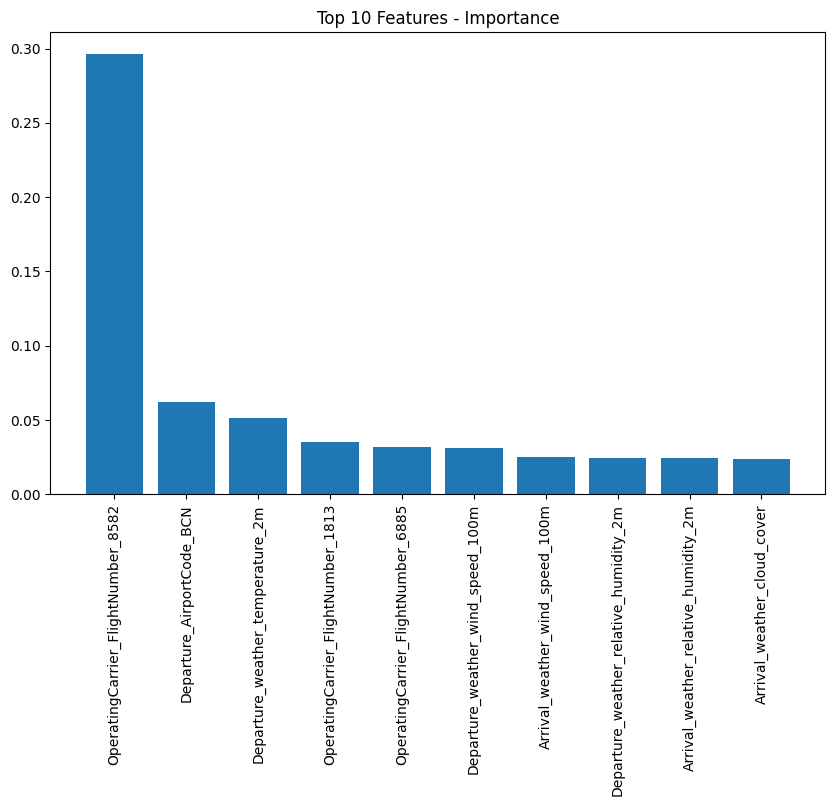

In [32]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X_train.columns[indices][:10], rotation=90)
plt.title("Top 10 Features - Importance")
plt.show()

In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import requests
import os
from flatten_json import flatten
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import logging

API_BASE_URL = "http://localhost:8000"  # Utiliser l'IP externe si configuré
endpoint = '/flights-all-future'

print(str(datetime.now()) + "start machine learning data cleanup")
try:
    response = requests.get(f"{API_BASE_URL}{endpoint}", timeout=10)
    if response.status_code == 200:
        dict_flattened = (flatten(record, '_') for record in response.json())
        df = pd.DataFrame(dict_flattened)
        df_minimized = df.drop(['MarketingCarrierList_MarketingCarrier_AirlineID',
               'MarketingCarrierList_MarketingCarrier_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_0_AirlineID',
               'MarketingCarrierList_MarketingCarrier_0_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_1_AirlineID',
               'MarketingCarrierList_MarketingCarrier_1_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_2_AirlineID',
               'MarketingCarrierList_MarketingCarrier_2_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_3_AirlineID',
               'MarketingCarrierList_MarketingCarrier_3_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_4_AirlineID',
               'MarketingCarrierList_MarketingCarrier_4_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_5_AirlineID',
               'MarketingCarrierList_MarketingCarrier_5_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_6_AirlineID',
               'MarketingCarrierList_MarketingCarrier_6_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_7_AirlineID',
               'MarketingCarrierList_MarketingCarrier_7_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_8_AirlineID',
               'MarketingCarrierList_MarketingCarrier_8_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_9_AirlineID',
               'MarketingCarrierList_MarketingCarrier_9_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_10_AirlineID',
               'MarketingCarrierList_MarketingCarrier_10_FlightNumber',
               'MarketingCarrierList_MarketingCarrier_11_AirlineID',
               'MarketingCarrierList_MarketingCarrier_11_FlightNumber', 'Departure_Terminal_Gate',
                               'Arrival_Terminal_Name', 'Arrival_Terminal_Gate',
                               'Departure_Terminal_Name',
                               'Status_Description', 'Departure_Status_Description', 'Arrival_Status_Description', 'future'], axis=1)
        print(df_minimized.columns)
except Exception as e:
    print(f"Erreur API {endpoint} : {e}")

df_minimized['Departure_Actual_Datetime'] = pd.to_datetime(df['Departure_Actual_Date'] + ' ' + df['Departure_Actual_Time'])
df_minimized['Arrival_Actual_Datetime'] = pd.to_datetime(df['Arrival_Actual_Date'] + ' ' + df['Arrival_Actual_Time'])
df_minimized['Departure_Scheduled_Datetime'] = pd.to_datetime(df['Departure_Scheduled_Date'] + ' ' + df['Departure_Scheduled_Time'])
df_minimized['Arrival_Scheduled_Datetime'] = pd.to_datetime(df['Arrival_Scheduled_Date'] + ' ' + df['Arrival_Scheduled_Time'])

df_w_datetime = df_minimized.drop(['Departure_Actual_Date', 'Departure_Actual_Time', 'Arrival_Actual_Date', 'Arrival_Actual_Time', 'Departure_Scheduled_Date', 'Departure_Scheduled_Time', 'Arrival_Scheduled_Date', 'Arrival_Scheduled_Time'], axis=1)

df_w_datetime['is_delayed'] = df_w_datetime['Arrival_Actual_Datetime'] > df_w_datetime['Arrival_Scheduled_Datetime']

df_w_datetime["delay (min)"] = np.where(
    df_w_datetime["is_delayed"],
    (df_w_datetime["Arrival_Actual_Datetime"] - df_w_datetime["Arrival_Scheduled_Datetime"]).astype(int)/(60*(10**9)),
    -(df_w_datetime["Arrival_Scheduled_Datetime"] - df_w_datetime["Arrival_Actual_Datetime"]).astype(int)/(60*(10**9))
)

df_w_datetime_red = df_w_datetime.drop(['Arrival_Estimated_Date', 'Arrival_Estimated_Time', 'Departure_Estimated_Date', 'Departure_Estimated_Time'], axis=1)

values = {
    "Departure_weather_rain": df_w_datetime_red['Departure_weather_rain'].median(), 
    "Departure_weather_snowfall": df_w_datetime_red['Departure_weather_snowfall'].median(), 
    "Departure_weather_temperature_2m": df_w_datetime_red['Departure_weather_temperature_2m'].median(),
    "Departure_weather_relative_humidity_2m": df_w_datetime_red['Departure_weather_relative_humidity_2m'].median(), 
    "Departure_weather_wind_speed_100m": df_w_datetime_red['Departure_weather_wind_speed_100m'].median(),
    "Departure_weather_cloud_cover": df_w_datetime_red['Departure_weather_cloud_cover'].median(),
    "Arrival_weather_rain": df_w_datetime_red['Arrival_weather_rain'].median(), 
    "Arrival_weather_snowfall": df_w_datetime_red['Arrival_weather_snowfall'].median(), 
    "Arrival_weather_temperature_2m": df_w_datetime_red['Arrival_weather_temperature_2m'].median(),
    "Arrival_weather_relative_humidity_2m": df_w_datetime_red['Arrival_weather_relative_humidity_2m'].median(), 
    "Arrival_weather_wind_speed_100m": df_w_datetime_red['Arrival_weather_wind_speed_100m'].median(),
    "Arrival_weather_cloud_cover": df_w_datetime_red['Arrival_weather_cloud_cover'].median(),
    "Departure_Actual_Datetime": df_w_datetime_red['Departure_Scheduled_Datetime']
}

df_no_na = df_w_datetime_red.fillna(value=values)

df_final = df_no_na.drop(['Departure_weather_time', 'Arrival_weather_time', '_id', 'is_delayed'], axis=1)

# Exemple : extraire heure, jour, mois, jour de semaine
df_final['Dep_Sched_Hour'] = df_final['Departure_Scheduled_Datetime'].dt.hour
df_final['Dep_Sched_Day'] = df_final['Departure_Scheduled_Datetime'].dt.day
df_final['Dep_Sched_Month'] = df_final['Departure_Scheduled_Datetime'].dt.month
df_final['Dep_Sched_Weekday'] = df_final['Departure_Scheduled_Datetime'].dt.weekday

df_final['Arr_Sched_Hour'] = df_final['Arrival_Scheduled_Datetime'].dt.hour
df_final['Arr_Sched_Day'] = df_final['Arrival_Scheduled_Datetime'].dt.day
df_final['Arr_Sched_Month'] = df_final['Arrival_Scheduled_Datetime'].dt.month
df_final['Arr_Sched_Weekday'] = df_final['Arrival_Scheduled_Datetime'].dt.weekday



df_final_split = df_final.drop(columns=[
    'Departure_Scheduled_Datetime', 'Arrival_Scheduled_Datetime',
    'Departure_Actual_Datetime', 'Arrival_Actual_Datetime'
])

print(df_final_split)

2025-10-13 21:20:49.854166start machine learning data cleanup
Erreur API /flights-all-future : "['MarketingCarrierList_MarketingCarrier_AirlineID', 'MarketingCarrierList_MarketingCarrier_FlightNumber', 'MarketingCarrierList_MarketingCarrier_0_AirlineID', 'MarketingCarrierList_MarketingCarrier_0_FlightNumber', 'MarketingCarrierList_MarketingCarrier_1_AirlineID', 'MarketingCarrierList_MarketingCarrier_1_FlightNumber', 'MarketingCarrierList_MarketingCarrier_2_AirlineID', 'MarketingCarrierList_MarketingCarrier_2_FlightNumber', 'MarketingCarrierList_MarketingCarrier_3_AirlineID', 'MarketingCarrierList_MarketingCarrier_3_FlightNumber', 'MarketingCarrierList_MarketingCarrier_4_AirlineID', 'MarketingCarrierList_MarketingCarrier_4_FlightNumber', 'MarketingCarrierList_MarketingCarrier_5_AirlineID', 'MarketingCarrierList_MarketingCarrier_5_FlightNumber', 'MarketingCarrierList_MarketingCarrier_6_AirlineID', 'MarketingCarrierList_MarketingCarrier_6_FlightNumber', 'MarketingCarrierList_MarketingCarr

KeyError: 'Departure_Actual_Date'